<a href="https://colab.research.google.com/github/sharmin6630/Sentiment-analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sentiment Analysis using Neural Network**

**Dataset** : IMDB Dataset of 50K Movie Reviews from Kaggle 

https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

which have been combined from http://ai.stanford.edu/~amaas/data/sentiment/

#**Drive mount**

In [137]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Importing Libraries**

In [138]:
#processing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re,string,unicodedata
from textblob import TextBlob
from textblob import Word

#nltk Libraries
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer

#scikit-learn Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

#Keras Libraries
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.layers import Activation, Dropout, Dense, Flatten, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import text_to_word_sequence

# **Reading Dataset and Exploring**

In [139]:
data = pd.read_csv('/content/gdrive/MyDrive/imdb dataset/IMDB Dataset.csv')

In [140]:
print(data.shape)
data.head(5)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


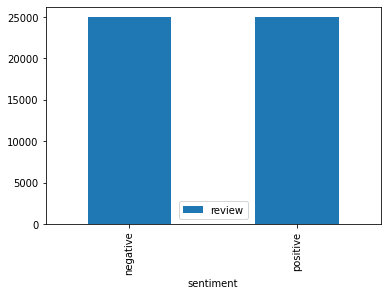

In [141]:
data.groupby('sentiment').count().plot(kind='bar')  #balanced data

In [142]:
data.review[0] #needs preprocessing

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

#**DATA Preprocessing**

### **Cleaning**

In [143]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [144]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [145]:
#converting to lower case
data["review"] = data["review"].apply(lambda x: x.lower()) 

#removing everything instead of 0-9, a-z, A-Z
data["review"] = data["review"].apply(lambda x: re.sub("[^0-9a-zA-Z]"," ", x))

#removing html tags
clean_html = re.compile('<.*?>')
data["review"] = data["review"].apply(lambda x: re.sub(clean_html, "", x))

#lemmatizing
data["review"] = data["review"].apply(lambda x: lemmatizer.lemmatize(x))

#removing extra white spaces
data["review"] = data["review"].apply(lambda x: re.sub(" +"," ", x) )

In [146]:
data.head(5)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production br br the filmin...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is a...,positive


In [147]:
data.review[0] #cleaned data

'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away br br i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t 

### **Label Encoding**

In [148]:
y = data['sentiment'].values
le = LabelEncoder()
y = le.fit_transform(y)

### **Tokenization**

In [149]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], y, test_size=0.20, random_state=42) #splitting 

In [150]:
max_features = 10000
# the number of words in the vocab = 10000
# 10000 is basically the number of unique words, ie. vocabulary size is 10000
# so the first 10000 relevant words will be used.

tokenizer = Tokenizer(max_features) # Generate index for each string based on frequency (more frequent ; lesser the index value)
tokenizer.fit_on_texts(X_train) # Only the words available in "fit_on_texts" will be considered. Others will be ignored  
print("\nNumber of unique words in training set") 
print(len(tokenizer.word_index))


Number of unique words in training set
92480


In [151]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [152]:
vocab_size = len(tokenizer.word_index) + 1

# Setting maximum length of each list(review) to be of length 300 words
maxlen = 300

# Making the train and test statements to be of size 300 by truncating or padding accordingly
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### **Building Dictionary using Glove Embedding**


In [153]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/gdrive/MyDrive/imdb dataset/glove.6B.100d.txt', encoding="utf8")


for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

### **Embedding Matrix**

In [154]:
embedding_matrix = np.zeros((vocab_size, 100))

# Getting vector representation (from embedding dictionary) of each word in word_index
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    #If word is not available in GloVE embedding text file, that word will be skipped
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [155]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37771001,  0.22946   , -0.30311   , ..., -0.33610001,
         0.02637   , -0.72302002],
       [ 0.99882001,  0.044     ,  0.58508003, ..., -0.54869002,
         0.15141   ,  1.36880004]])

# **Recurrent Neural Network Model**

In [194]:
rnn_model = Sequential() 
# Since GloVe predefined embedding is used, "trainable" is set to False
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
rnn_model.add(embedding_layer)
rnn_model.add(Dropout(0.5))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(512, activation='relu'))
rnn_model.add(Dropout(0.5))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1, activation='sigmoid'))

In [203]:
#Compiling the model
rnn_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])

In [204]:
rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 100)          9248100   
_________________________________________________________________
dropout_28 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 300, 100)          400       
_________________________________________________________________
dropout_29 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
dense_14 (Dense)             (None, 300, 512)          51712     
_________________________________________________________________
dropout_30 (Dropout)         (None, 300, 512)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 300, 512)         

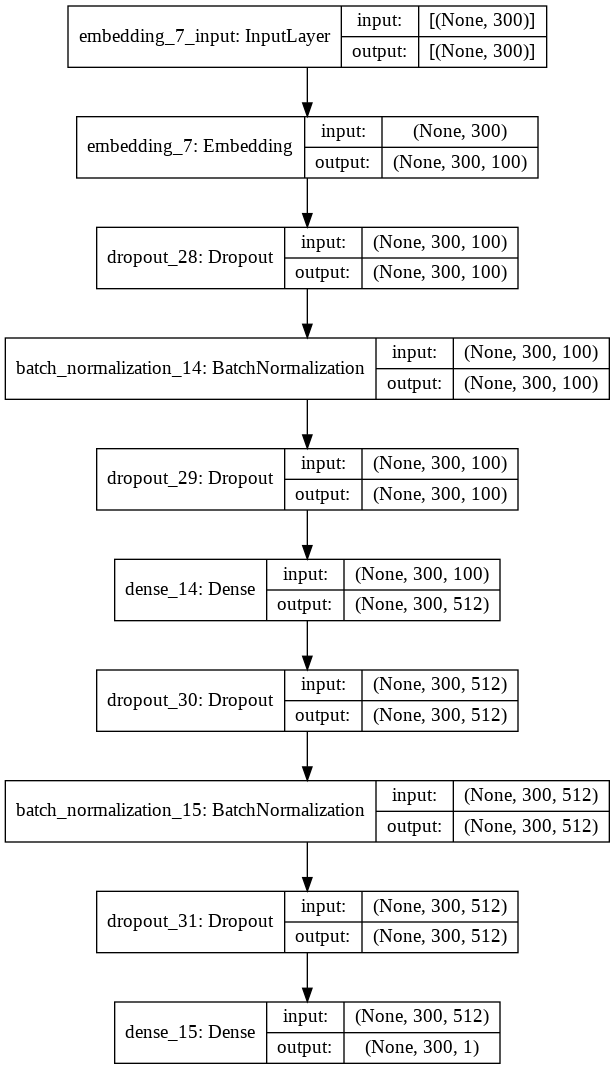

In [205]:
from keras.utils.vis_utils import plot_model
plot_model(rnn_model, show_shapes=True, show_layer_names=True)

### **RNN Model Training**

In [206]:
# Training our model
rnn_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 12s 39ms/step - loss: 0.8176 - acc: 0.5042 - val_loss: 0.6917 - val_acc: 0.5239
Epoch 2/6
250/250 [==============================] - 9s 38ms/step - loss: 0.6926 - acc: 0.5103 - val_loss: 0.6912 - val_acc: 0.5240
Epoch 3/6
250/250 [==============================] - 9s 38ms/step - loss: 0.6923 - acc: 0.5135 - val_loss: 0.6914 - val_acc: 0.5222
Epoch 4/6
250/250 [==============================] - 9s 38ms/step - loss: 0.6921 - acc: 0.5142 - val_loss: 0.6906 - val_acc: 0.5244
Epoch 5/6
250/250 [==============================] - 9s 38ms/step - loss: 0.6921 - acc: 0.5150 - val_loss: 0.6909 - val_acc: 0.5253
Epoch 6/6
250/250 [==============================] - 9s 38ms/step - loss: 0.6919 - acc: 0.5156 - val_loss: 0.6912 - val_acc: 0.5218


# **RNN Model Accuracy**

In [207]:
# model's accuracy on train set
rnn_score_val = rnn_model.evaluate(X_train, y_train, verbose=1)
print("Train loss:", rnn_score_val[0])
print("Train Accuracy:", rnn_score_val[1])

1250/1250 [==============================] - 5s 4ms/step - loss: 0.6912 - acc: 0.5223
Train loss: 0.6911547780036926
Train Accuracy: 0.5223497748374939


In [162]:
print("\n\n\nRecurrent Neural Network")
print("Traning Accuracy : {}" .format(rnn_history.history['acc']))
print("Validation Accuracy : {}" .format(rnn_history.history['val_acc']))
print("\nTraning Loss : {}" .format(rnn_history.history['loss']))
print("Validation Loss : {}" .format(rnn_history.history['val_loss']))





Recurrent Neural Network
Traning Accuracy : [0.5059135556221008, 0.5130141377449036, 0.5133534669876099, 0.5161685943603516, 0.5149152278900146, 0.5150834321975708]
Validation Accuracy : [0.5206770896911621, 0.5230216383934021, 0.5194474458694458, 0.5204029679298401, 0.5239799618721008, 0.5252959132194519]

Traning Loss : [0.7386090755462646, 0.6924653053283691, 0.6922634243965149, 0.692122757434845, 0.6921048760414124, 0.6919894814491272]
Validation Loss : [0.6920756101608276, 0.6913135647773743, 0.6911435127258301, 0.6909893751144409, 0.6907156705856323, 0.6907169818878174]


In [163]:
# Evaluating the model's accuracy
rnn_score = rnn_model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", rnn_score[0])
print("Test Accuracy:", rnn_score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.6906 - acc: 0.5291
Test loss: 0.6905775666236877
Test Accuracy: 0.5290592908859253


# **Result Visualization RNN**

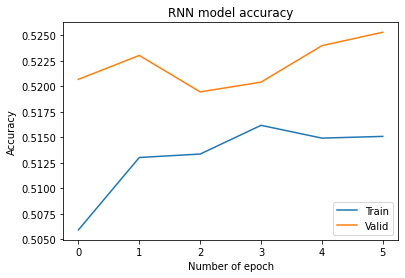

In [164]:
# Plotting accuracy graph for model built
plt.title('RNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.plot(rnn_history.history['acc'], label = 'Train')
plt.plot(rnn_history.history['val_acc'], label = 'Valid')
plt.legend(loc='best')
plt.show()

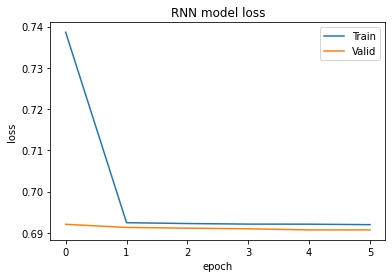

In [165]:
# Loss graph
plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(rnn_history.history['loss'], label = 'Train')
plt.plot(rnn_history.history['val_loss'], label = 'Valid')
plt.legend(loc='best')
plt.show()

# **Convolution Neural Network Model**

In [166]:
cnn_model = Sequential()
# Since GloVe predefined embedding is used, "trainable" is set to False
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(1024, 3, padding='valid', activation='relu', strides=1)) # 1D CNN as 2D CNN is genrally used for images
cnn_model.add(GlobalMaxPooling1D()) # Pooling is done to avoid overfitting and reduces the dimension of data
cnn_model.add(Dropout(0.5))
cnn_model.add(BatchNormalization()) # used as regularization to avoid overfitting of the model
cnn_model.add(Dropout(0.5)) # neurons are dropped-out randomly
cnn_model.add(Dense(2048, activation='relu')) # relu helps to converge much more quickly 
cnn_model.add(Dropout(0.5))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid')) # sigmoid as there are two classes 

In [167]:
#Compiling the model
cnn_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])

In [168]:
# Printing the model summary
print(cnn_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 100)          9248100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 298, 1024)         308224    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 1024)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)             

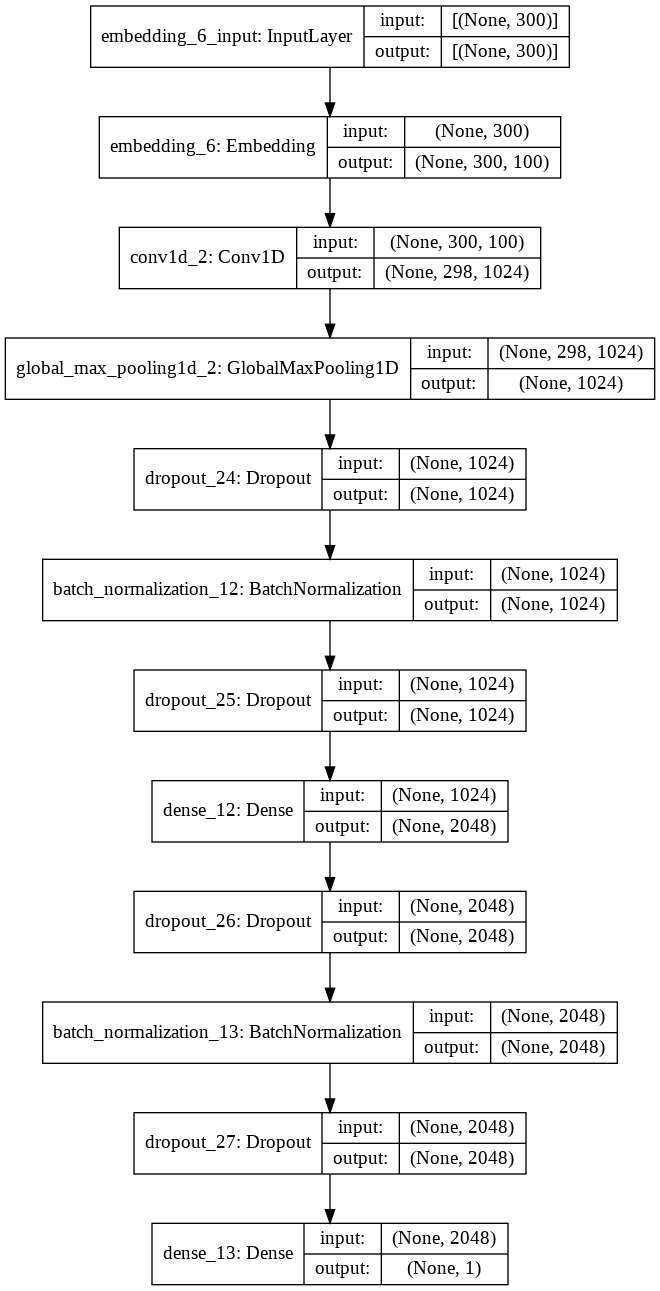

In [169]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

## **CNN Model Training**

In [170]:
# Training model
cnn_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 12s 42ms/step - loss: 0.8491 - acc: 0.6141 - val_loss: 0.4089 - val_acc: 0.8326
Epoch 2/6
250/250 [==============================] - 10s 40ms/step - loss: 0.4579 - acc: 0.7877 - val_loss: 0.3625 - val_acc: 0.8440
Epoch 3/6
250/250 [==============================] - 10s 41ms/step - loss: 0.4034 - acc: 0.8154 - val_loss: 0.3246 - val_acc: 0.8622
Epoch 4/6
250/250 [==============================] - 10s 41ms/step - loss: 0.3767 - acc: 0.8331 - val_loss: 0.3249 - val_acc: 0.8586
Epoch 5/6
250/250 [==============================] - 10s 41ms/step - loss: 0.3608 - acc: 0.8386 - val_loss: 0.3032 - val_acc: 0.8763
Epoch 6/6
250/250 [==============================] - 10s 41ms/step - loss: 0.3494 - acc: 0.8459 - val_loss: 0.2967 - val_acc: 0.8776


# **CNN Model Accuracy**

In [171]:
# model's accuracy on train set
cnn_score_val = cnn_model.evaluate(X_train, y_train, verbose=1)
print("Test loss:", cnn_score_val[0])
print("Test Accuracy:", cnn_score_val[1])

1250/1250 [==============================] - 8s 6ms/step - loss: 0.2580 - acc: 0.8974
Test loss: 0.2580452263355255
Test Accuracy: 0.897350013256073


In [172]:
print("\n\n\nConvolution Neural Network")
print("Traning Accuracy : {}" .format(cnn_history.history['acc']))
print("Validation Accuracy : {}" .format(cnn_history.history['val_acc']))
print("\nTraning Loss : {}" .format(cnn_history.history['loss']))
print("Validation Loss : {}" .format(cnn_history.history['val_loss']))





Convolution Neural Network
Traning Accuracy : [0.6822500228881836, 0.7943124771118164, 0.8171250224113464, 0.8331249952316284, 0.8384374976158142, 0.8462187647819519]
Validation Accuracy : [0.8326249718666077, 0.843999981880188, 0.8622499704360962, 0.8586249947547913, 0.8762500286102295, 0.8776249885559082]

Traning Loss : [0.6885315775871277, 0.44682472944259644, 0.40516573190689087, 0.379604697227478, 0.36256343126296997, 0.3508267402648926]
Validation Loss : [0.4088558852672577, 0.3624865710735321, 0.32455018162727356, 0.3249105215072632, 0.3031773269176483, 0.29668647050857544]


In [173]:
# Evaluating the model's accuracy
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", cnn_score[0])
print("Test Accuracy:", cnn_score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.3012 - acc: 0.8716
Test loss: 0.3012373149394989
Test Accuracy: 0.8715999722480774


# **Result Visualization CNN**

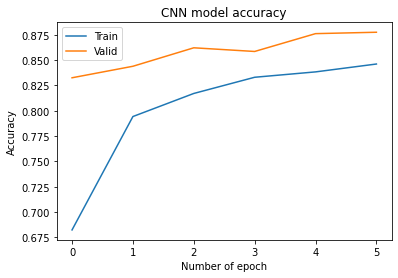

In [174]:
# Plotting accuracy graph for model built
plt.title('CNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.plot(cnn_history.history['acc'], label = 'Train')
plt.plot(cnn_history.history['val_acc'], label = 'Valid')
plt.legend(loc='best')
plt.show()

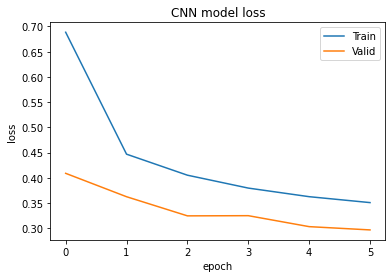

In [175]:
# Loss graph
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(cnn_history.history['loss'], label = 'Train')
plt.plot(cnn_history.history['val_loss'], label = 'Valid')
plt.legend(loc='best')
plt.show()

# **Making Prediction on custom user input**

In [195]:
def predict_input(user_input):
    # Converting text to numeric form Using the tokenizer built earlier
    reviewText = text_to_word_sequence(user_input)
    reviewProcessed = tokenizer.texts_to_sequences(reviewText)

    flat_list = []
    for sublist in reviewProcessed:
        for item in sublist:
            flat_list.append(item)

    #Making the entire items as a single list
    flat_list = [flat_list]
    #Padding to fit into model
    reviewSequence = pad_sequences(flat_list, padding='post', maxlen=maxlen)

    #Predicting the sentiment of review using three models
    print("'0 to 0.5' - Negative, '0.51 - 1' - Positive")
    label_rnn = 'Negative'
    predicted_ans_rnn = rnn_model.predict(reviewSequence)
    if max(predicted_ans_rnn.flatten()) > 0.5:
        label_rnn = 'Positive'
    print("\nPredition by Recurrent Neural network model is:", label_rnn, max(predicted_ans_rnn.flatten()))

    label_cnn = 'Negative'
    predicted_ans_cnn = cnn_model.predict(reviewSequence)
    if predicted_ans_cnn > 0.5:
        label_cnn = 'Positive'
    print("\nPredition by Convolution Neural network model is:", label_cnn, predicted_ans_cnn)

### **Give an input to test the model prediction**

In [196]:
user_input = input()
predict_input(user_input)

The movie had some deep concept. It kept me glued to the screen
'0 to 0.5' - Negative, '0.51 - 1' - Positive

Predition by Recurrent Neural network model is: Positive 0.569495

Predition by Convolution Neural network model is: Positive [[0.53963816]]


In [197]:
user_input = input()
predict_input(user_input)

The movie was amazing
'0 to 0.5' - Negative, '0.51 - 1' - Positive

Predition by Recurrent Neural network model is: Positive 0.569495

Predition by Convolution Neural network model is: Positive [[0.9889263]]


In [198]:
user_input = input()
predict_input(user_input)

The movie had many plot holes
'0 to 0.5' - Negative, '0.51 - 1' - Positive

Predition by Recurrent Neural network model is: Positive 0.569495

Predition by Convolution Neural network model is: Negative [[0.1909628]]


In [199]:
user_input = input()
predict_input(user_input)

This movie is trash
'0 to 0.5' - Negative, '0.51 - 1' - Positive

Predition by Recurrent Neural network model is: Positive 0.569495

Predition by Convolution Neural network model is: Negative [[0.05455159]]
